<a href="https://colab.research.google.com/github/semant/MachineLearning/blob/master/LSTM_German_English_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# German-English Language Translation using LSTM

> Semant Jain, PhD semant@gmail.com

### Executive Summary
> **Introduction**

> Another application of long short-term memory (LSTM) neural networks is in language translation. However, compared to sentiment analysis, this is a much more challenging problem as the same word can have multiple contextual meanings. Regardless, in this project, a two layer LSTM model with 20% dropout was constructed which was trained on 100,000 German/English translations -- constraints within the computational limits -- of Google colaboratry GPU. This training was completed within 20-30 minutes and the recreated sentences were largely able to capture the essential meaning of the original sentences.

> **Architecture**
> + Encoder layer had 512 embedding vector and 2 LSTM layers with 20% dropout
> + Decoder layer had 2 LSTM layers with 20% dropout

> **Computational Constraints**
> + As this LSTM model was being trained on Google Colab GPU, the training had to be limited to under 30 minutes. Thereafter, execution was observed to time out.
> + While the total German/English translation library has 204,574 entries, using more than 100,000 entries caused RAM limits to be exceeded.
> + After 30 epochs, the training error was still decreasing but the validation error stopped decreasing.

> **Conclusions** 
>  Despite the computational constraints, after training for 20 minutes, the LSTM model was able to exactly recreate or capture the essential meaning for most of the original sentence in its recreation. With greater computational resources, the following improvements could be tested:
+ For training purposes, greater sentence and dictionary length
+ More LSTM layers, higher dropout rates, addition of attention models, and greater training time


### Contents
+ Setting up
  + Importing libraries
  + Importing data
  + Preprocessing
  + Setting maximum translation length
+ Model
  + Architecture
  + Optimizer
  + Execution
+ Results
  + Reverse dictionary
  + Recreated results


### Libraries
+ Keras
+ Matplotlib
+ Numpy
+ Pandas
+ Sklearn
+ String




# 1. Setting up

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pandas as pd
import string

from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.models import load_model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Importing data

In [2]:
!wget http://www.manythings.org/anki/deu-eng.zip

--2020-01-24 04:10:42--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7747747 (7.4M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.39M  18.0MB/s    in 0.4s    

2020-01-24 04:10:43 (18.0 MB/s) - ‘deu-eng.zip’ saved [7747747/7747747]



In [3]:
!unzip deu-eng.zip

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


#### Helper functions

In [4]:
def read_text(filename):
  file = open(filename, mode = 'rt', encoding = 'utf-8') 
  text = file.read()
  file.close()
  return text

def to_lines(text):
  pairs = text.strip().split('\n')
  # Split each line
  sents = [p.split('\t') for p in pairs] 
  return sents 

data = read_text("deu.txt")
deu_eng = to_lines(data) 
deu_eng = np.array(deu_eng)

print(deu_eng[0])

def encode_sequences(tokenizer, length, lines):
  # Convert each word in sentences to tokens (list of numbers)
  seq = tokenizer.texts_to_sequences(lines) 
  seq = pad_sequences(seq, maxlen = length, padding = 'post')
  return seq

['Hi.' 'Hallo!'
 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']




```
# This is formatted as code
```

### Limiting dictionary length
+ Complete: 204,574
+ Limit:    100,000

In [5]:
print(len(deu_eng))

deu_eng = deu_eng[:100000, :] #50,000
print(len(deu_eng))

204574
100000


In [6]:
deu_eng 

array([['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Run!', 'Lauf!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ['What line of work are you in?', 'Was machen Sie beruflich?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #54432 (CK) & #3190973 (Pfirsichbaeumchen)'],
       ['What other choice did I have?',
        'Was hätte ich anderes tun können?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2439797 (Hybrid) & #2439807 (Pfirsichbaeumchen)'],
       ['What other options do I have?',
        'Was für andere Optionen habe ich?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1449 (Zifre) & #251 (MUIRIEL)']],
      dtype='<U537')

### Pre-processing
+ Remove caps
+ Remove punctuation

In [0]:
deu_eng[:, 0] = [s.translate (str.maketrans("", "", string.punctuation)) for s in deu_eng[:, 0]]
deu_eng[:, 1] = [s.translate (str.maketrans("", "", string.punctuation)) for s in deu_eng[:, 1]]


### Splitting German and English translations

In [8]:
deu_eng[:, :2]

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['What line of work are you in', 'Was machen Sie beruflich'],
       ['What other choice did I have',
        'Was hätte ich anderes tun können'],
       ['What other options do I have',
        'Was für andere Optionen habe ich']], dtype='<U537')

In [9]:
for i in range(len(deu_eng)):
  deu_eng[i,0] = deu_eng[i,0].lower()
  deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng[:, :2]

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['what line of work are you in', 'was machen sie beruflich'],
       ['what other choice did i have',
        'was hätte ich anderes tun können'],
       ['what other options do i have',
        'was für andere optionen habe ich']], dtype='<U537')

### Setting maximum length of the translations

**Current maximum length**

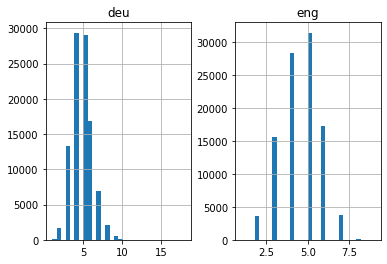

In [10]:
eng_len = [len(s.split()) for s in deu_eng[:, 0]]
deu_len = [len(s.split()) for s in deu_eng[:, 1]]
lengths_df = pd.DataFrame({'eng': eng_len, 'deu':deu_len})
lengths_df.hist(bins = 30)
plt.show()

In [11]:
# Maximum lengths - limited by first 50,000 cases
print(max(eng_len))
print(max(deu_len))

9
18


In [0]:
#lengths_df.max(axis=0)

**Setting Maximum Length**

In [13]:
eng_max_length = min(10, max(eng_len)) # 8
deu_max_length = min(10, max(deu_len)) # 8

print(eng_max_length, deu_max_length)

9 10


### Tokenizer

In [14]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(deu_eng[:,0])

eng_vocab_size = len(eng_tokenizer.word_index) + 1 # len is the total number of tokens. So, add 1 to account for padding (token 0)
print(eng_vocab_size) # 6344 + 1 for extra token

9468


In [0]:
# eng_tokenizer.word_index

In [16]:
deu_tokenizer = Tokenizer()
deu_tokenizer.fit_on_texts(deu_eng[:,1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
print(deu_vocab_size) 

17192


### Train Test split

In [17]:
train, test = train_test_split(deu_eng, test_size = 0.2, random_state = 12) 

trainX = encode_sequences(deu_tokenizer, deu_max_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_max_length, train[:, 0])

print(trainX.shape, trainY.shape)
print(trainX[0], trainY[0])

(80000, 10) (80000, 9)
[ 1 80  8  0  0  0  0  0  0  0] [ 2 30  8  0  0  0  0  0  0]


### Testing data

In [18]:
testX = encode_sequences(deu_tokenizer, deu_max_length, test[:,1]) 
testY = encode_sequences(eng_tokenizer, eng_max_length, test[:,0]) 

print(testX.shape, testY.shape)

(20000, 10) (20000, 9)



# 2. Model

### Architecture



In [19]:
# Hyperparameter
Dropout = 0.2


# ENCODING
model = Sequential()
model.add(Embedding(deu_vocab_size,
                    512,  
                    input_length = deu_max_length, 
                    mask_zero = True)) 
model.add(LSTM(512, return_sequences=True, dropout = Dropout)) 
model.add(LSTM(512, dropout = Dropout))


# DECODING - TEACHER FORCING
model.add(RepeatVector(eng_max_length)) 

model.add(LSTM(512, return_sequences = True, dropout = Dropout))
model.add(LSTM(512, return_sequences = True, dropout = Dropout))
model.add(Dense(eng_vocab_size, activation = "softmax"))
model.summary() 





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 512)           8802304   
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 512)           2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 9, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 9, 512)            2099200   
_______________________________________

### Optimizer

In [20]:
rms = optimizers.RMSprop(lr = 0.001)
model.compile(optimizer = rms, loss = 'sparse_categorical_crossentropy')

### Add Checkpoints

In [0]:
filename = "model.h1.2020_01_23" 
checkpoint = ModelCheckpoint(filename,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

### Execution

In [22]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs = 30,
                    batch_size = 512, 
                    validation_split = 0.2, 
                    callbacks = [checkpoint])




Train on 64000 samples, validate on 16000 samples
Epoch 1/30





64000/64000 [==============================] - 44s 693us/step - loss: 3.4708 - val_loss: 3.0811

Epoch 00001: val_loss improved from inf to 3.08109, saving model to model.h1.2020_01_23
Epoch 2/30
64000/64000 [==============================] - 31s 487us/step - loss: 3.0192 - val_loss: 2.8971

Epoch 00002: val_loss improved from 3.08109 to 2.89706, saving model to model.h1.2020_01_23
Epoch 3/30
64000/64000 [==============================] - 32s 494us/step - loss: 2.8185 - val_loss: 2.7572

Epoch 00003: val_loss improved from 2.89706 to 2.75717, saving model to model.h1.2020_01_23
Epoch 4/30
64000/64000 [==============================] - 32s 493us/step - loss: 2.6559 - val_loss: 2.6132

Epoch 00004: val_loss improved from 2.75717 to 2.61317, saving model to model.h1.2020_01_23
Epoch 5/30
64000/64000 [==============================] - 31s 489us/step - loss: 2.5400 - val_loss: 2.5557

Epoch 00005: val_loss improved from 2.

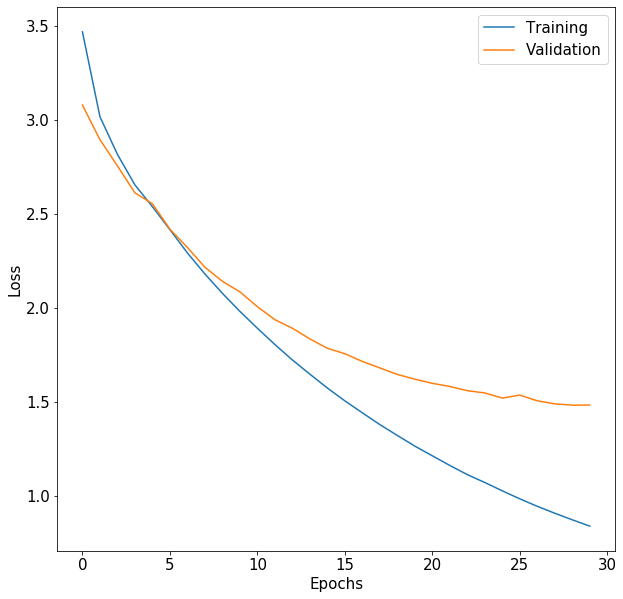

In [36]:
plt.figure (figsize = (10,10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'], fontsize = 15)
plt.savefig('CE_ML_Project_12_01_Loss.jpeg')
plt.show()

In [24]:
print(testX.shape)

(20000, 10)


In [0]:
model = load_model(filename) 
preds = model.predict_classes(testX)

# 3. Results
### Creating a Reverse Dictionary
+ Current dictionary has word as key and number as token
+ Need token -> word

In [0]:
eng_dict = { t:w for w,t in eng_tokenizer.word_index.items() }

In [0]:
eng_preds = []
for p in preds:
  sent = [] # Sentences
  for t in p:
    w = eng_dict.get(t) if t > 0 else "" 
    sent.append(w)
  eng_preds.append(' '.join(sent)) 

### Compare predicted v. test english sentences

**Top 15 translations**

In [28]:
pred_df = pd.DataFrame({'actual':test[:, 0], 'predicted': eng_preds})
pred_df.head(15)

,actual,predicted
0,when are you busy,when are you busy
1,she wore a long loose coat,she was a long blue blue
2,i have nothing to write,i have nothing to to talk
3,i borrow money,i going for money
4,tom wrung the chickens neck,tom put the fire on
5,he gave me a ride home,he gave me home
6,i swim regularly,i am my eggs
7,can i tell you something,can i tell you something
8,i go to school with him,i go to school school
9,take my car,take my car


**Bottom 15 translations**

In [29]:
pred_df.tail(15)

,actual,predicted
19985,maybe tom doesnt like me,maybe tom didnt believe tom
19986,how often do you read books,how often do you books books
19987,are all of these books yours,are those these books books
19988,what is your name sir,how your your son is
19989,tom says hell give it a try,tom says hell try it
19990,hes writing a long letter,he is a a of of
19991,the snow lasted four days,it rained three days days days
19992,he is very mean to me,he is very to to me
19993,tom is a fast talker,tom speaks fast
19994,i ran for my life,i ran to my my


**Random 15 translations**

In [30]:
pred_df.sample(15)

,actual,predicted
12330,i dont know that guys name,i dont know his name name
6996,are you free now,are you come time
8968,tom comes from a small town,tom is in a small town
3151,she trusted you,they trusted you
4880,i dont like it at all,i dont like it it all
456,who allowed that,who wrote this
15331,i want to stay longer,i want to eat abroad
2683,my job is teaching english,i used as as a
1964,id be happy to go with you,id be happy to talk you you
10838,i envy her,i envy you
